This project utilizes the Titanic Dataset from the Kaggle Titanic competition. The goal is to explore the data and create a model to predict the survival of an individual based on the given features or those that are engineered.

<h2>1. Import Libraries and Acquire Data</h2>

In [1]:
# Data analysis and cleaning
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
from matplotlib import cycler
%matplotlib inline
import seaborn as sns
# !pip install --upgrade ptitprince
import ptitprince as pt

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb 
from sklearn import metrics

# Default Styling
colors_default = ['#17869E', '#D35151', '#e5ae38', '#6d904f', '#264D58', '#E9DAB4']
colors_highlight = ['#51C4D3', '#fc4f30','#ffd966', '#9AE19D', '#008fd5']
darks = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors = cycler('color',colors_default)
style=plt.style.use('fivethirtyeight')
plt.rc('axes', prop_cycle=colors)
plt.rc('lines', linewidth=1)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('font', size=10)

/Users/ryanpalazini/opt/anaconda3/envs/py39/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
combined_df = pd.concat([train_df, test_df], ignore_index=True)

print('\nTest Dataframe:')
test_df.info()
print('='*45)
print('\nTrain Dataframe:')
train_df.info()
print('\n')
train_df.head()


Test Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB

Train Dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     89

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<h1>2. Data Cleaning</h1>

In [3]:
for df in [train_df, test_df]:
    # Age null values will be imputed with the mean Age of each Pclass due to their high correlation (shown later)
    Age_mean = df.groupby('Pclass')['Age'].mean()
    df['Age'] = df.apply(
        lambda row: Age_mean[row['Pclass']]
        if np.isnan(row['Age'])
        else row['Age'], axis=1
    )
    
    # Fare null values will be imputed with the mean Age of each Pclass due to their high correlation (shown later)
    Fare_mean = df.groupby('Pclass')['Fare'].mean()
    df['Fare'] = df.apply(
        lambda row: Fare_mean[row['Pclass']]
        if np.isnan(row['Fare'])
        else row['Fare'], axis=1
    )
    
    # Embarked null values will be imputed based on the mode
    Mode = df['Embarked'].mode()[0]
    df['Embarked'].fillna(Mode, inplace=True)

<h4> 2.2 Create:</h4> Feature Engineering for train and test/validation dataset

In [4]:
for df in [train_df, test_df, combined_df]:    
    # Column indicating total family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    
    # Column indicating if passenger has immediate family aboard
    df['FamilyAboard'] = 0 # Initialize to No/0
    df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
    
    # Fare Bins/Buckets using qcut or frequency bins
    df['FareBin'] = pd.qcut(df['Fare'], 5)
    
    # Age Bins/Buckets using cut or value bins: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html
    df['AgeBin'] = pd.cut(x=df['Age'], bins=[0,18,30,40,50,65,85])
   
    # Create a column for the passenger's title -- http://www.pythonforbeginners.com/dictionary/python-split
    df['Title'] = df['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
        
# Cleanup rare title names
stat_min = 10 # While 'rare' is arbitrary, we'll use a common minimum in statistics
              # http://nicholasjjackson.com/2012/03/08/sample-size-is-10-a-magic-number/
title_names = (combined_df.loc[:,'Title'].value_counts() < stat_min) # Creates true/false series with title as index
    
for df in [train_df, test_df]:
    df['Title'] = df.loc[:,'Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)

/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['FamilyAboard'].loc[df['FamilySize'] > 1] = 1 # Update to Yes/1 if family size is greater than 1
/var/folders/2g/tckg1pmx4jj_vmtn556g6xwm0000gn/T/ipykernel_16164/1683422142.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [5]:
# PassengerId, Ticket, Name columns will be dropped because they are arbitrary (title already extracted)
# Cabin column will be dropped because it is missing a high portion of data
for df in [train_df, test_df]:
    df.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
train_df.drop('PassengerId',axis=1, inplace=True) # Column kept in test_df for submission 

<h2>3. Exploratory Data Analysis</h2>

Note: There is some redundancy in the EDA charts due to exercising a variety of plotting methods and chart types

In [6]:
# Discrete Variable Correlation by Survival using group by aka pivot table:
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.groupby.html
for col in train_df:
    if (train_df[col].dtype != 'float64') and (col != 'Survived'):
        print('Survival Correlation by:', col)
        print(train_df[[col, 'Survived']].groupby(col, as_index=False).mean().sort_values(by='Survived', ascending=False))
        print('-'*10, '\n')      
        
# using crosstabs: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.crosstab.html
print(pd.crosstab(train_df['Title'], train_df['Survived']))

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
3      3  0.600000
1      1  0.550847
2      2  0.500000
0      0  0.343658
5      5  0.200000
4      4  0.000000
6      6  0.000000
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.339009
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
3           4  0.724138
2           3  0.578431
1           2  0.552795
6           7  0.333333
0           1  0.303538
4           5  0.200000
5           6  0.136364
7           8  0.00000

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.0, 1, 'by Survival Outcome')

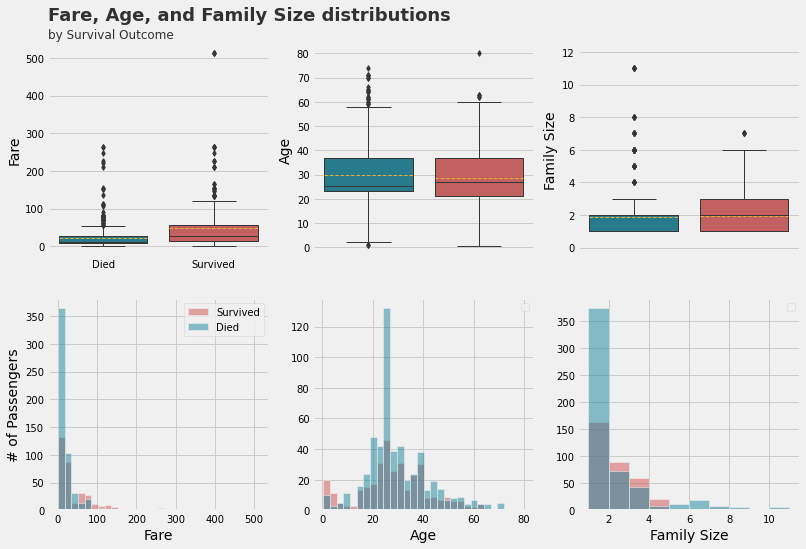

In [7]:
# This is one method to create subplots, but the prefered method is used in upcoming visualizations
plt.figure(figsize=[12,8])

plt.subplot(231)
sns.boxplot(x=train_df['Survived'], y=train_df['Fare'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Fare')
plt.xlabel('')
plt.xticks(ticks=[0,1], labels=['Died','Survived'])

plt.subplot(232)
sns.boxplot(x=train_df['Survived'], y=train_df['Age'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Age')
plt.xlabel('')
plt.xticks([])

plt.subplot(233)
sns.boxplot(x=train_df['Survived'], y=train_df['FamilySize'], showmeans = True, meanline = True, fliersize=4)
plt.ylabel('Family Size')
plt.ylim(-0.5,12.5)
plt.xlabel('')
plt.xticks([])

plt.subplot(234)
sns.histplot(data=train_df, x='Fare', hue='Survived', bins=30)
plt.xlabel('Fare')
plt.ylabel('# of Passengers')
plt.legend(['Survived','Died'])

plt.subplot(235)
sns.histplot(data=train_df, x='Age', hue='Survived', bins=30)
plt.ylabel('')
plt.legend()

plt.subplot(236)
sns.histplot(data=train_df, x='FamilySize', hue='Survived', bins=10)
plt.xlabel('Family Size')
plt.ylabel('')
plt.legend()

# Title and subtitle
plt.subplot(231)
plt.text(s="Fare, Age, and Family Size distributions", ha='left', x=-0.5, y=600, fontsize=18, fontweight='bold', color=darks[1])
plt.title("by Survival Outcome", loc='left', fontsize=12, y=1, color=darks[1]) 

Text(0.52, 0.9, 'Survival Rates by Feature')

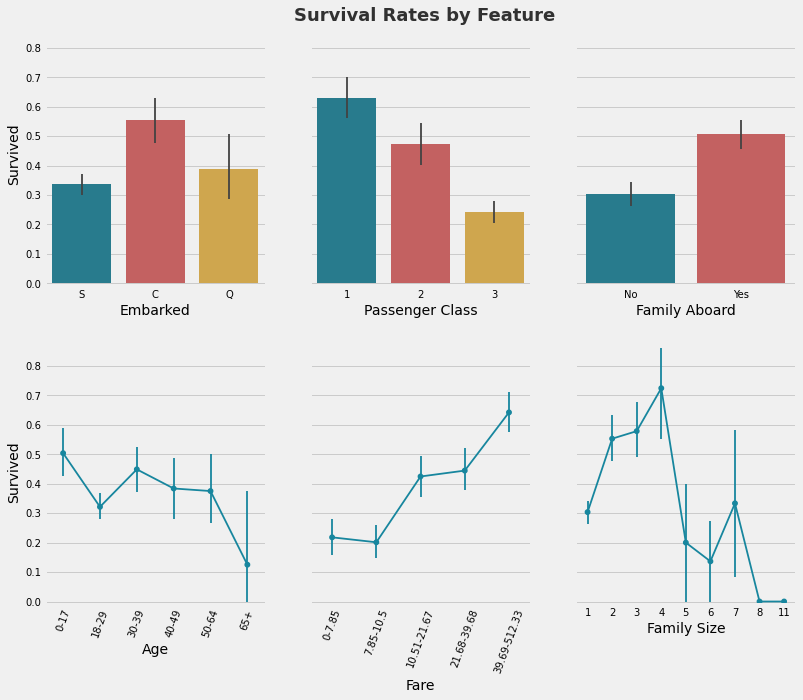

In [8]:
# Create Figure and subplots
fig, axs = plt.subplots(2, 3, figsize=(12,10), sharey=True)

# Plot
sns.barplot(data=train_df, x='Embarked', y='Survived', ax=axs[0,0])
sns.barplot(data=train_df, x='Pclass', y='Survived', ax=axs[0,1])
sns.barplot(data=train_df, x='FamilyAboard', y='Survived', ax=axs[0,2])
sns.pointplot(data=train_df, x='AgeBin', y='Survived', ax=axs[1,0])
sns.pointplot(data=train_df, x='FareBin', y='Survived', ax=axs[1,1])
sns.pointplot(data=train_df, x='FamilySize', y='Survived', ax=axs[1,2])

# Format
axs[0,1].set(xlabel='Passenger Class', ylabel='')
axs[0,2].set(xlabel='Family Aboard', ylabel='',  xticklabels=['No','Yes'])
axs[1,0].set(xlabel='Age', 
             xticklabels=['0-17','18-29','30-39','40-49','50-64', '65+'],
             ylim=(-0.01,0.89))
axs[1,0].tick_params(axis='x',rotation=70)
axs[1,1].set(ylabel='', xlabel='Fare', xticklabels=['0-7.85','7.85-10.5','10.51-21.67','21.68-39.68','39.69-512.33'])
axs[1,1].tick_params(axis='x', rotation=70)
axs[1,2].set(xlabel='Family Size',ylabel='')

fig.suptitle('Survival Rates by Feature', fontsize=18, fontweight=600, x=0.52, y=0.9, color=darks[1])

Text(0.0, 1.1, 'by on Passenger Class and Survival Outcome')

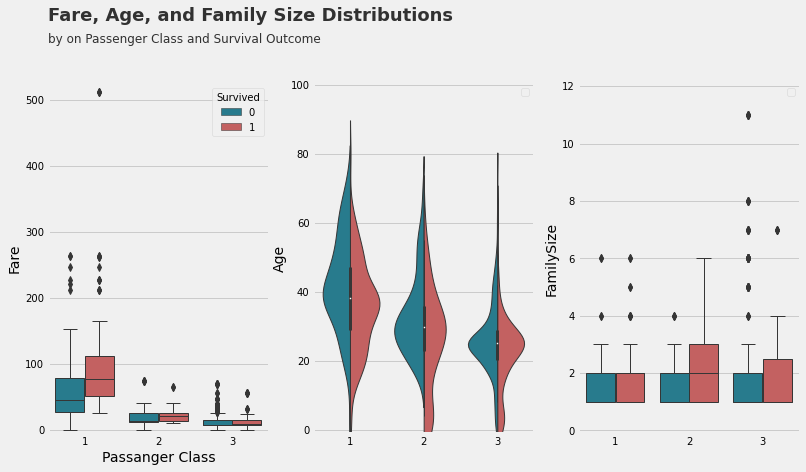

In [9]:
fig, axs = plt.subplots(1,3,figsize=(12,6))

sns.boxplot(data=train_df, x='Pclass', y='Fare', hue='Survived', ax=axs[0])
axs[0].set(xlabel='Passanger Class', ylim=(-5,525))
plt.legend(['Survived','Died'])

sns.violinplot(data=train_df, x='Pclass', y='Age', hue='Survived', split=True, ax=axs[1])
axs[1].set(xlabel='', ylim=(-1,100.5))
axs[1].legend('')

sns.boxplot(data=train_df, x='Pclass', y='FamilySize', hue='Survived', ax=axs[2])
axs[2].set(xlabel='', ylim=(-0.1,12.1))
axs[2].legend('')

# Title and Subtitle
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()

plt.subplot(131)
plt.text(s='Fare, Age, and Family Size Distributions',
         x=xmin, y=ymax*1.18, fontsize=18, fontweight='bold', color=darks[1])
plt.title("by on Passenger Class and Survival Outcome", loc='left', fontsize=12, y=1.1, color=darks[1]) 

Text(0.0, 1.04, 'by features Passenger Class, Family Aboard, and Embarked')

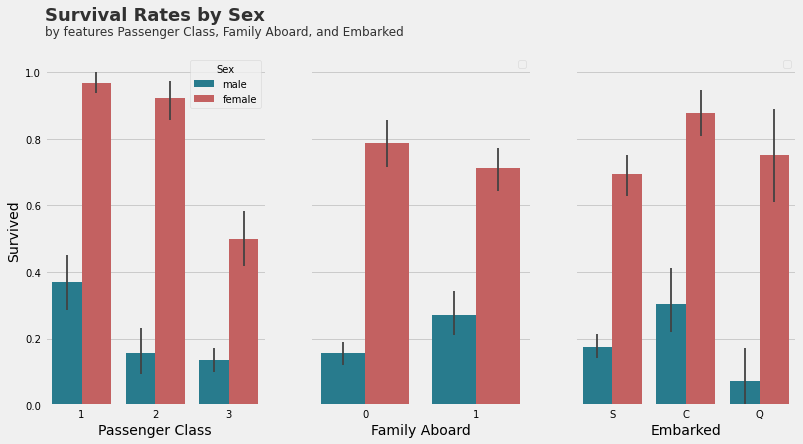

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,6), sharey=True)

sns.barplot(data=train_df, x='Pclass', y='Survived', hue='Sex', ax=axs[0])
axs[0].set(xlabel='Passenger Class')

sns.barplot(
    data=train_df,
    x='FamilyAboard',
    y='Survived',
    hue='Sex',
    ax=axs[1])
axs[1].set(xlabel='Family Aboard', ylabel='')
axs[1].legend('')

sns.barplot(
    data=train_df,
    x='Embarked',
    y='Survived',
    hue='Sex',
    ax=axs[2])
axs[2].set(ylabel='')
axs[2].legend('')

# Title and Subtitle
xmin, xmax = axs[0].get_xlim()
ymin, ymax = axs[0].get_ylim()

plt.subplot(131)
plt.text(s='Survival Rates by Sex',
         x=xmin,
         y=ymax*1.1,
         fontsize=18,
         fontweight='bold',
         color=darks[1])
plt.title("by features Passenger Class, Family Aboard, and Embarked",
          loc='left',
          fontsize=12,
          y=1.04,
          color=darks[1]) 

Text(0.48, 1.02, 'Survival Rates by Family Size and Age')

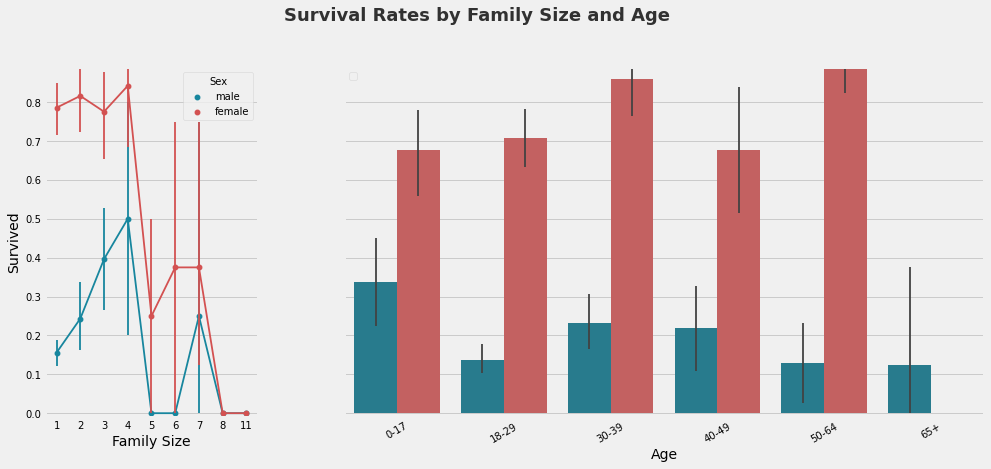

In [11]:
fig, axs = plt.subplots(1,2, figsize=(15,6), gridspec_kw={'width_ratios':[1,3]}, sharey=True)

sns.pointplot(data=train_df, x='FamilySize', y='Survived', hue='Sex', ax=axs[0])
axs[0].set(xlabel='Family Size')

sns.barplot(data=train_df, x='AgeBin', y='Survived', hue='Sex', ax=axs[1])
axs[1].set(
    xlabel='Age', ylabel='', 
    xticklabels=['0-17','18-29','30-39','40-49','50-64', '65+'],
    ylim=(-0.01,0.89))
axs[1].tick_params(axis='x', rotation=30)
axs[1].legend('')

fig.suptitle('Survival Rates by Family Size and Age', fontsize=18, fontweight=600, x=0.48, y=1.02, color=darks[1]) 

<Figure size 1008x576 with 0 Axes>

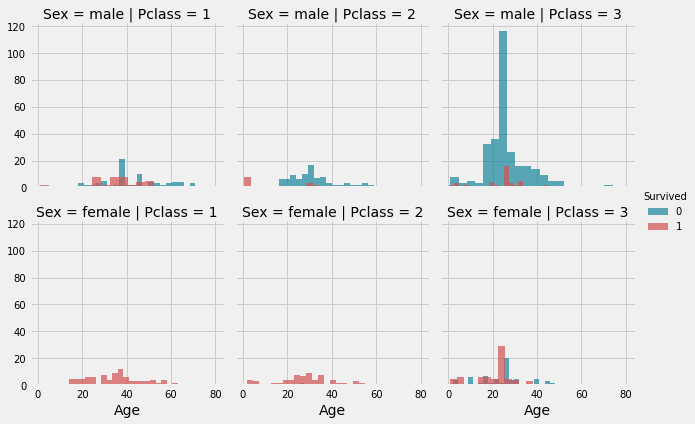

In [12]:
grid = sns.FacetGrid(train_df, col='Pclass', row='Sex', hue='Survived')
plt.figure(figsize=(14,8))
grid.map(plt.hist, 'Age', bins=20, alpha=0.7)
grid.add_legend()

Text(0.51, 0.96, 'Age Distribution by Passenger Class')

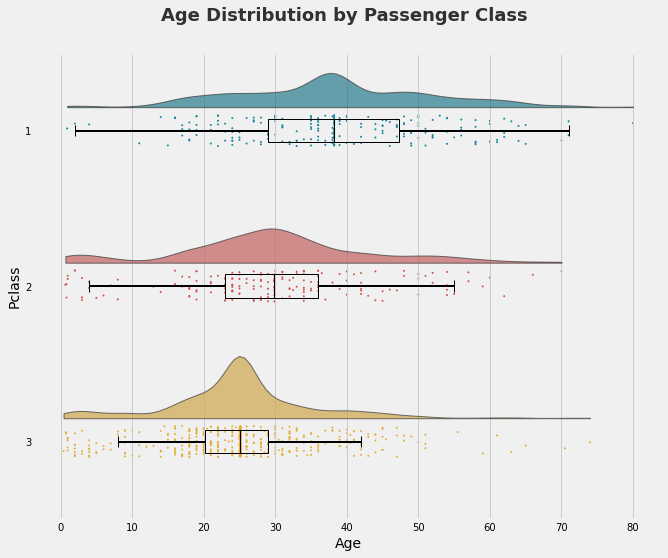

In [13]:
# Rainplot
fig, ax = plt.subplots(figsize=(10, 8))

ax=pt.half_violinplot(
    data=train_df, x='Age', y='Pclass', palette=colors_default, orient='h', alpha=0.7,
    bw=.2, linewidth=1,cut=0., scale="area", width=.8, inner=None)
ax=sns.stripplot(
    data=train_df, x='Age', y='Pclass', palette=colors_default, orient='h',
    edgecolor="white",size=2,jitter=1,zorder=0)
ax=sns.boxplot(
    data=train_df, x='Age', y='Pclass', color="black",orient='h',
    width=.15,zorder=10,showcaps=True,boxprops={'facecolor':'none', "zorder":10},
    showfliers=False,whiskerprops={'linewidth':2, "zorder":10},saturation=1)

fig.suptitle('Age Distribution by Passenger Class', fontsize=18, fontweight=600, x=0.51, y=0.96, color=darks[1])

Text(0.51, 0.96, 'Age Distribution by Survival')

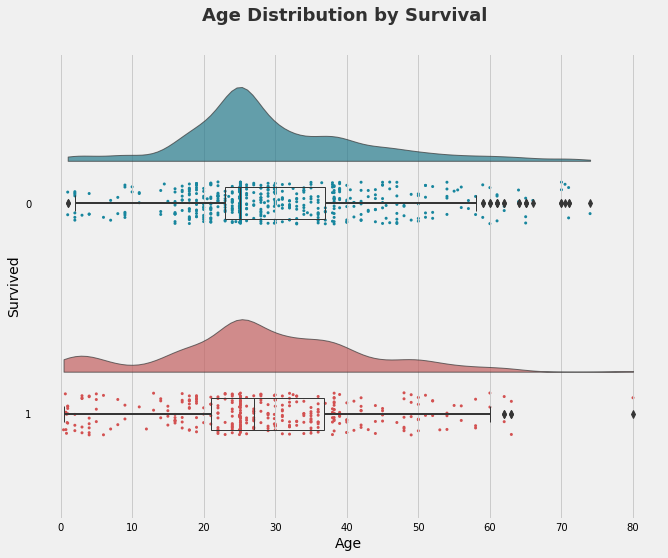

In [14]:
# Below is a higher level method of creating a rainplot, requiring less code
fig, axs = plt.subplots(figsize=(10, 8))

axs=pt.RainCloud(
    data=train_df, x='Survived', y='Age', alpha=0.7,
    bw=0.2, ax = axs, orient = 'h', palette=colors_default, dodge=True)

fig.suptitle('Age Distribution by Survival', fontsize=18, fontweight=600, x=0.51, y=0.96, color=darks[1])

<AxesSubplot:>

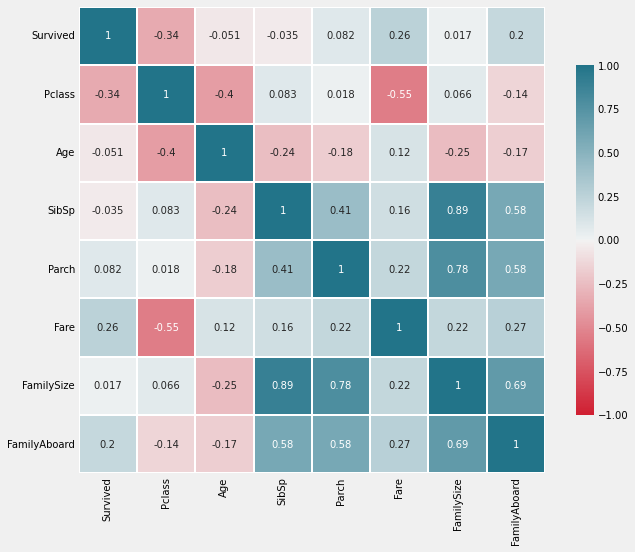

In [15]:
plt.figure(figsize=(10,8))
sns.heatmap(
    train_df.corr(), 
    cmap = sns.diverging_palette(10, 220, as_cmap=True, l=45, s=90), 
    annot=True, 
    square=True,
    vmin=-1,
    vmax=1,
    cbar_kws={'shrink':.75 },
    linewidths=0.08, linecolor='white')

<h2>4. Model and Predict Data</h2>

<h3> 4.0 Prepare Data</h3>

<h4>Convert</h4>

In [16]:
for df in [train_df, test_df]:
    # Create dummy variables for categorical columns
    df = pd.concat([df, pd.get_dummies(df[['Sex','Embarked','Title', 'Sex']], drop_first=True)], axis=1)
    
    # Remove original categorical columns
    df.drop(['Sex', 'Embarked', 'Title'], axis=1, inplace=True)
    
    # Drop bin columns used for visualization. This data is already present in numerical columns
    df.drop(['AgeBin', 'FareBin'], axis=1, inplace=True)

<h4>Create</h4>

In [17]:
# Create dummy variables for categorical columns
train_df = pd.concat([train_df, pd.get_dummies(train_df[['Sex','Embarked','Title']], drop_first=True)], axis=1)
test_df = pd.concat([test_df, pd.get_dummies(test_df[['Sex','Embarked','Title']], drop_first=True)], axis=1)

# Drop original categorical columns. Drop bin columns used for visualization--data is already present in numerical columns
train_df.drop(['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin'], axis=1, inplace=True)
test_df.drop(['Sex', 'Embarked', 'Title', 'AgeBin', 'FareBin'], axis=1, inplace=True)

<h4>Split</h4>

In [18]:
X=train_df.drop('Survived', axis=1)
y=train_df['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=101)

<h3> 4.1 Random Forest Classifier</h3>

<img style="width: 440px; height: 221px;" src="https://www.explorium.ai/wp-content/uploads/2019/12/Decision-Trees-2.png" align="Right">

Random Forest Classifiers are upgraded versions of Decision Trees by creating an ensemble of many models using the method of bagging (or "Bootstrap Aggregation").

The foundational Decision Trees Classifier is an intuitive model. The model will first split the data/rows/samples by each its value for one particular column/field/variable/feature/variable (let's stick "sample" with "variable"). The goal of this split is to make each sample subsethave more homogenous values for the target variable. After splitting the samples at this <i>root node</i>, the model repeats this process for each <i>branch</i> by utilizing additional variables as <i>decision nodes</i>. The goal is to end with <i>leaf nodes</i> that accurately classify the samples in that node as one particular class.

A key concern here is <i>which feature should be used for each decision?</i> This can be determined by a variety of metrics, but the most common are Entropy and Gini Index. In brief...
 
<p style="padding-left: 10px;">
$Gini = 1-\sum_{i=1}^{n}{(p_{i})^{2}}$<br>
$Entropy = -\sum_{i=1}^{n}{p_{i} log_{2}(p_i)}$</p>

where $P_{i}$ denotes the porportion of samples belonging to class $i$ for that particular node. In other words, the probability of data being classified for a distinct class. These metrics range from 0 to 1, where 0 is best (most "pure" for gini and most "ordered" for Entropy). The Gini Index tends to favor nodes with larger partitions and Entropy tends to favor nodes with smaller partitions and more distinct classes.

The greatest downfall to a Decision Tree model is it tends to overfit because it is highly dependent on the data the model is trained with. There are several parameters to help counteract this, such as min and max number of samples before splitting, min and max tree depth, etc. One of the greatest methods to prevent overfitting is <i>bagging</i> which creates the <b><i>Random Forest Classifier</i></b>.

RFC creates an ensemble of Decision Trees such that each one is trained using only a subset (wih replacement) of the entire dataset--this is known as bagging. Additionally, each Decision Tree can be limited to making decisions based on only a subset of all variables. These two restrictions help establish "a large number of relatively uncorrelated models (trees) operating as a committee [that outperforms] any of the individual constituent models." These Decision Trees are created in parallel so the Random Forest Classifier can make predicitions based on the average of the trees. Note that the SciKit-Learn RFC uses subsets are selected with replacement, but are always the same size as the original sample set.

In [ ]:
# RFC Benchmark Model
rfc = RandomForestClassifier(random_state=101)
rfc.fit(X_train,y_train)

# Random Forest Classifier with Random Feature Elimiation
rfc_rfe = RFECV(
    RandomForestClassifier(random_state=101),
    step = 1,
    scoring = 'roc_auc',
    cv=4)

rfc_rfe.fit(X_train, y_train)
selected_features = X.columns.values[rfc_rfe.get_support()]

rfc_rfe = RandomForestClassifier(random_state=101)
rfc_rfe = rfc_rfe.fit(X_train[selected_features], y_train)

# Use GridSearchCV to improve Random Forest Classifier parameters
rfc_params = {
    'n_estimators':[100, 150, 200],
    'criterion': ['gini', 'entropy'],  
    'max_depth': [4,6,8,10,None],
    'min_samples_split': [2,5,10,20],
    'random_state': [101]}

rfc_tuned = GridSearchCV(
    RandomForestClassifier(random_state=101),
    rfc_params,verbose=1,
    scoring = 'roc_auc',
    cv=4)

rfc_tuned.fit(X_train[selected_features], y_train)

In [ ]:
# Print best parameters and selected features
print('Selected Features:', selected_features,'\n')
print('Best Parameters:', rfc_tuned.best_params_)

<h3>4.2 Support Vector Machine Classifier</h3>

<img style="width: 414px; height: 180px;" src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSDlYsiPUl636bhR-MBaBDkSgOQdwEJAmXdKg&usqp=CAU" align="Right">
In brief, Support Vector Machines represent samples as points in space. The goal is to identify a hyperplane--known as the <i>Decision Boundary</i>--that separates the distinct classes as clearly as possible (as large of a separation as possible). If these classes are not linearly separable, then the <i>Kernel Trick</i> will map the data to another dimension to improve separability. SVMs tend to perform at a higher speed and performance when samples are limited than other modern models, like Neural Networks. For large amounts of data, however, these models can become very computationally expensive.

In [ ]:
# SVC Benchmark Model
svc = SVC(probability=True)
svc.fit(X_train,y_train)

# SVC with tuned parameters using GridSearchCV
svc_params = {'C':[0.1,1,10,100,1000, 10000], 'gamma':[1,0.1,0.01,0.001,0.0001]}
svc_tuned = GridSearchCV(SVC(),svc_params,verbose=1, scoring='roc_auc', cv=4)
svc_tuned.fit(X,y)

<h3>4.3 XGBoost</h3>

The bagging method was used in the Random Forest Classifier to combat overfitting. Another method to control bias-variance tradeoff that utilizes models built in <u>series</u> instead of parallel is <i>boosting</i>. For Gradient Boosting, a loss function is used to detect the residuals of the individual <i>weak learners</i>, such as Decision Trees. Gradient Descent is utilized to minimize the loss function when creating the next model. The final model aggregates the result of each step (creates ensemble) and thus a strong learner is obtained.


Gradient Boosted Decision Trees (GBDTs) iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions. XGBoost is short for eXtreme Gradient Boosting and predominantly aims to improve speed and performance of the Gradient Boost with all the same foundational theory.

Some quick tips for the XGBoost library:
* can handle missing values if they are not dealt with in preprocessing
* cannot handle categorical features
* Transform data to DMatrix structure, which is an optimized data structure that provides better memory efficiency and training speed.

In [ ]:
# Store data in DMatrix object
ddata = xgb.DMatrix(data=X, label=y)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

# XGB Benchmark Model
# Specify parameters
num_round = 500 # Early stopping will be applied
xgb_params = {
    'max_depth':2,
    'learning_rate':1,
    'objective':'binary:logistic',
    'eval_metric':['logloss','auc']} # last metric listed used for early_stopping

# Cross Validation
xgb_cv = xgb.cv(
    xgb_params,
    ddata,
    num_round,
    nfold=4,
    early_stopping_rounds=10,
    seed=101,
    callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]) # Will return mean+std

There are two main methods to combat overfitting a model:

1. Directly control model complexity.
    * For a tree model, this includes max_depth, min_child_weight and gamma (min split loss).
2. Add randomness to make training robust to noise.
    * For a tree model, this includes subsample and colsample_bytree.
    * Reduce stepsize eta ("learning rate"). If this is done, num_round should be increased.

The training data (including validation, just not the final test data) is moderately imbalanced (38%). Since the model is concerned with predicting the correct outcome and not necessarily the predicting the correct probabilities, data will be balanced (see <a href="https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html?highlight=balance">XGB documentation</a>).

XGBoost library does not have any GridSearchCV sort of function. It is absolutely possuble to use GridSearchCV, but it will not accept a DMatrix object for the data, greatly helps the speed of XGB. For this reason, xgb.cv() will be looped to achieve the same goal as GridSearchCV, but faster.

In [ ]:
ddata = xgb.DMatrix(data=X, label=y)
dtrain = xgb.DMatrix(data=X_train, label=y_train)
dval = xgb.DMatrix(data=X_val, label=y_val)

params_current = {
    'objective':'binary:logistic',
    'eval_metric':['logloss','auc']}

# Define preprocessing function to balance data with 'scale_pos_weight'
def fpreproc(dtrain, dtest, param):
    label = dtrain.get_label()
    ratio = float(np.sum(label == 0)) / np.sum(label == 1)
    param['scale_pos_weight'] = ratio
    return (dtrain, dtest, param)

auc_xgb_best = 0
params_xgb_best = None

for gam in [0,0.5,1]:
    params_current['gamma'] = gam
    
    for min_child in [0,15,35]:
        params_current['min_child_weight'] = min_child
        
        for max_dep in [2,4,6,None]:
            params_current['max_depth'] = max_dep
            
            for learn in [0.025,0.05,0.1,0.5,1]:
                params_current['learning_rate'] = learn
                
                for alpha in [0,0.5,1]:
                    params_current['reg_alpha'] = alpha
                    
                    for lamb in [0,0.5,1]:
                        params_current['reg_lambda'] = lamb
                
                        xgb_tuning = xgb.cv(
                            params_current,
                            ddata,
                            num_round,
                            nfold=4,
                            early_stopping_rounds=10,
                            fpreproc=fpreproc,
                            seed=101,
                            # return mean+std
                            callbacks=[xgb.callback.EvaluationMonitor(show_stdv=True)]) 

                        auc_result = xgb_tuning.iloc[-1]['test-auc-mean']

                        if  auc_result > auc_xgb_best:
                            auc_xgb_best = auc_result
                            params_xgb_best = params_current.copy()
                            xgb_best = xgb_tuning
                            
# Fit model to best parameters for final model comparison
xgb_tuned = xgb.train(
    params_xgb_best,
    dtrain,
    num_round,
    early_stopping_rounds=10,
    evals=[(dval,'Validation')])

For one last model, let's tune a boosted version of the top performing RFC.

In [ ]:
# Convert data with feature selection to DMatrix
ddata_feat = xgb.DMatrix(data=X[selected_features], label=y)
dtrain_feat = xgb.DMatrix(data=X_train[selected_features], label=y_train)
dval_feat = xgb.DMatrix(data=X_val[selected_features], label=y_val)

auc_xgbrf_best = 0
params_xgbrf_best = None

# Keep params of top RFC. Only boosting parameters will be tuned
for gamma in [0,0.5,0.75,1]:    
    for min_child in [0,1,2,3]:            
        for learn in [0.01, 0.05, 0.1]:
            for alpha in [0,0.5,0.75,1]:          
                for lamb in [0,0.5,1]:
                    
                    xgbrf_tuning = xgb.XGBRFClassifier(
                        n_estimators=100,
                        max_depth=8,
                        min_samples_split=5,
                        criterion ='gini',
                        learning_rate=learn,
                        gamma=gamma,
                        min_child_weight=min_child,
                        reg_alpha=alpha,
                        reg_lambda=lamb,
                        use_label_encoder=False)

                    xgbrf_tuning.fit(
                        X_train[selected_features],
                        y_train,
                        eval_set=[(X_val[selected_features], y_val)],
                        eval_metric=['logloss','auc'])

                    auc_result = xgbrf_tuning.evals_result_['validation_0']['auc'][0]

                    if  auc_result > auc_xgbrf_best:
                        auc_xgbrf_best = auc_result
                        params_xgbrf_best = xgbrf_tuning.get_params
                        xgbrf_tuned = xgbrf_tuning

In [26]:
model = ['RFC', 'RFC Feature Selection','RFC Tuned','RFC Boosted',
    'SVC','SVC Tuned','XGB', 'XGB Tuned']

metric_result = [
    metrics.roc_auc_score(y_val, rfc.predict_proba(X_val)[:,1]),
    metrics.roc_auc_score(y_val, rfc_rfe.predict_proba(X_val[selected_features])[:,1]),
    metrics.roc_auc_score(y_val, rfc_tuned.predict_proba(X_val[selected_features])[:,1]),   
    auc_xgbrf_best,
    metrics.roc_auc_score(y_val, svc.predict_proba(X_val)[:,1]),
    svc_tuned.best_score_,
    xgb_cv.iloc[-1]['test-auc-mean'],
    auc_xgb_best]

pd.DataFrame(metric_result, model, columns =['AUC_ROC'])

,AUC_ROC
RFC,0.844652
RFC Feature Selection,0.852608
RFC Tuned,0.855356
RFC Boosted,0.866757
SVC,0.787771
SVC Tuned,0.842567
XGB,0.868659
XGB Tuned,0.886647


<h3>Resources, References, Documentation:</h3><hr>

XGBoost resources: 
* <a href="https://xgboost.readthedocs.io/en/stable/python/python_intro.html#training">XGB Documentation: Python Package Introduction</a>
* <a href="https://xgboost.readthedocs.io/en/stable/tutorials/param_tuning.html">XGB Documentation: Notes on Parameter Tuning</a>
* <a href="https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d">TowardsDataScience: XGBoost Hyperparameter Tuning</a>
* <a href="https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance">Prashant Banerjee's Kaggle Notebook</a>
* <a href="https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/">Aarshay Jain: Parameter Tuning in XGboost</a>
* <a href="https://debuggercafe.com/a-guide-to-xgboost-in-python/">DeBuggerCafe: A Guide to XGBoost in Python</a>
* <a href="https://github.com/fmfn/BayesianOptimization/blob/master/README.md">Bayesian Optimizer for XGB</a>


Some visualization inspiration from fivethirtyeight:
* <a href="https://fivethirtyeight.com/features/the-52-best-and-weirdest-charts-we-made-in-2016/">2016 Best Charts</a>
* <a href="https://fivethirtyeight.com/features/the-56-best-and-weirdest-charts-we-made-in-2019/">2019 Best Charts</a>
* <a href="https://fivethirtyeight.com/features/the-40-weirdest-and-best-charts-we-made-in-2020/">2020 Best Charts</a>
* <a href="https://github.com/matplotlib/matplotlib/blob/38be7aeaaac3691560aeadafe46722dda427ef47/lib/matplotlib/mpl-data/stylelib/fivethirtyeight.mplstyle">fivethirtyeight default styling sheet</a>
* <a href="https://www.dataquest.io/blog/making-538-plots/">Example of making a simple fivethirtyeight style</a>

Miscellaneous:
* <a href="https://www.kaggle.com/ldfreeman3/a-data-science-framework-to-achieve-99-accuracy#Step-3:-Prepare-Data-for-Consumption">LD Freeman's Kaggle Notebook</a>
* <a href="https://towardsdatascience.com/understanding-random-forest-58381e0602d2">TowardsDataScience: Random Forest Classifier</a>
* <a href="https://matplotlib.org/stable/tutorials/introductory/customizing.html">Documentation for customizing with stylesheets and rcParams</a>
* <a href="https://wellcomeopenresearch.org/articles/4-63/v2">Why Use Rainplots</a>
* <a href="http://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html">To Visualize Decision Tress, use GraphViz</a>